In [2]:
conda install -c conda-forge prophet

Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

# All requested packages already installed.




In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import warnings
from fbprophet import Prophet
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_csv('D:\\Hamoye\\household_power_consumption\\household_power_consumption.txt', sep = ";", low_memory=False, infer_datetime_format=True, parse_dates={'Datetime':[0,1]}, index_col=['Datetime'])
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


In [6]:
df.replace("?", np.nan, inplace=True)

In [7]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [8]:
df = df.astype('float32')

In [9]:
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)

In [10]:
resampled_df = df.resample('D').sum()
resampled_df = resampled_df.reset_index()

In [11]:
corr, p = pearsonr(resampled_df['Global_active_power'], resampled_df['Global_reactive_power'])
print(f'pearson coreelation coefficient is: {round(corr, 2)}')

pearson coreelation coefficient is: 0.04


In [12]:
corr, p = pearsonr(resampled_df['Voltage'], resampled_df['Global_intensity'])
print(f'pearson coreelation coefficient is: {round(corr, 2)}')

pearson coreelation coefficient is: 0.05


In [13]:
data = resampled_df[['Datetime', 'Global_active_power']]
data = data.rename(columns={'Datetime': 'ds','Global_active_power': 'y'})

data.head(5)

,ds,y
0,2006-12-16,1209.176025
1,2006-12-17,3390.459961
2,2006-12-18,2203.825928
3,2006-12-19,1666.193970
4,2006-12-20,2225.748047


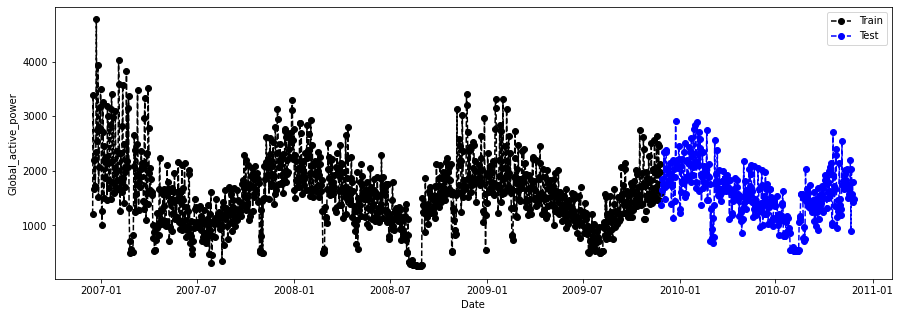

In [32]:
n_tests = 365
# train set
df_train = data[:-n_tests]

# test set
df_test = data[-n_tests:]

# visualize
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_train['ds'], df_train['y'], linestyle='--', marker='o', color='black', label='Train')
ax.plot(df_test['ds'], df_test['y'], linestyle='--', marker='o', color='blue', label='Test')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Global_active_power');

In [15]:
model = Prophet(weekly_seasonality=True, daily_seasonality=True)

In [16]:
# fit the model  on training data
model.fit(df_train);

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [17]:
forecast = model.predict(df_test)
forecast[['ds', 'yhat']].tail()

,ds,yhat
360,2010-11-22,2036.788940
361,2010-11-23,2178.947060
362,2010-11-24,2189.983356
363,2010-11-25,2022.624176
364,2010-11-26,2152.922822


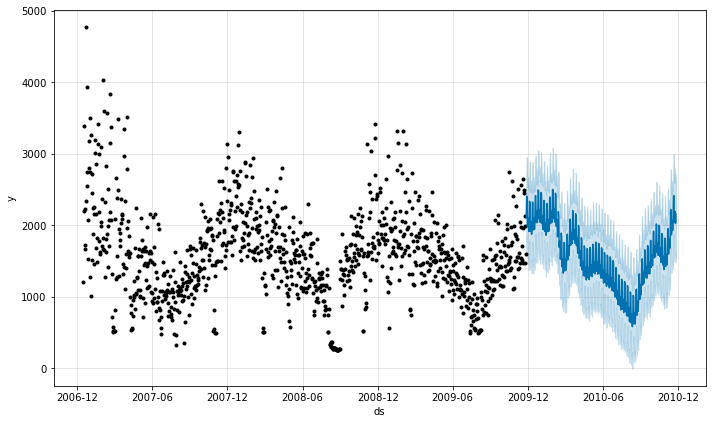

In [18]:
model.plot(forecast, uncertainty=True);

In [19]:
y_true = np.array(df_test['y'])
y_forecast = np.array(forecast['yhat'])
mape = np.mean(np.abs((y_true - y_forecast) / y_true)) * 100
print('The MAPE error is:', round(mape, 2))

The MAPE error is: 20.88


In [20]:
rmse = np.sqrt(mean_squared_error(y_true, y_forecast))
round(rmse,2)

374.98

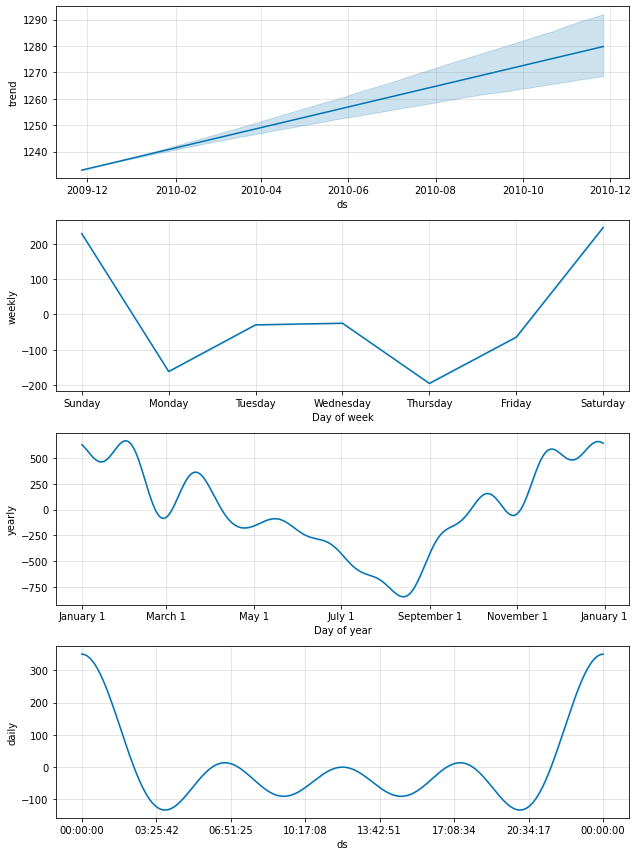

In [21]:
model.plot_components(forecast);

In [22]:

data['add1'] = resampled_df['Global_reactive_power']
data['add2'] = resampled_df['Voltage']
data['add3'] = resampled_df['Global_intensity']
data['add4'] = resampled_df['Sub_metering_1']
data['add5'] = resampled_df['Sub_metering_2']
data['add6'] = resampled_df['Sub_metering_3']

In [23]:
data.head()

,ds,y,add1,add2,add3,add4,add5,add6
0,2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
1,2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2,2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
3,2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
4,2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


In [24]:
n_tests = 365
df_train = data[:-n_tests]
df_test = data[-n_tests:]

In [25]:
new_model = Prophet(weekly_seasonality=True, daily_seasonality=True)
new_model.add_regressor('add1')
new_model.add_regressor('add2')
new_model.add_regressor('add3')
new_model.add_regressor('add4')
new_model.add_regressor('add5')
new_model.add_regressor('add6')
new_model.fit(df_train);

In [26]:
forecast = new_model.predict(df_test)

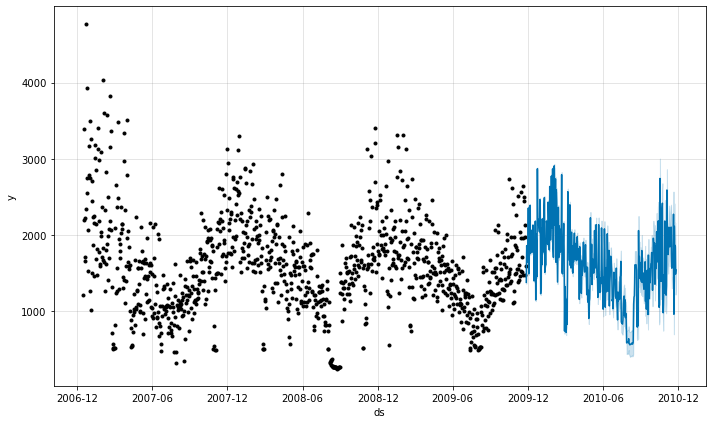

In [27]:
new_model.plot(forecast,uncertainty=True);

In [28]:
y_true = np.array(df_test['y'])
y_forecast = np.array(forecast['yhat'])
mape = np.mean(np.abs((y_true - y_forecast) / y_true)) * 100
print('The MAPE error is:', round(mape, 2))

The MAPE error is: 2.67


In [29]:
rmse = np.sqrt(mean_squared_error(y_true, y_forecast))
round(rmse,2)

39.75

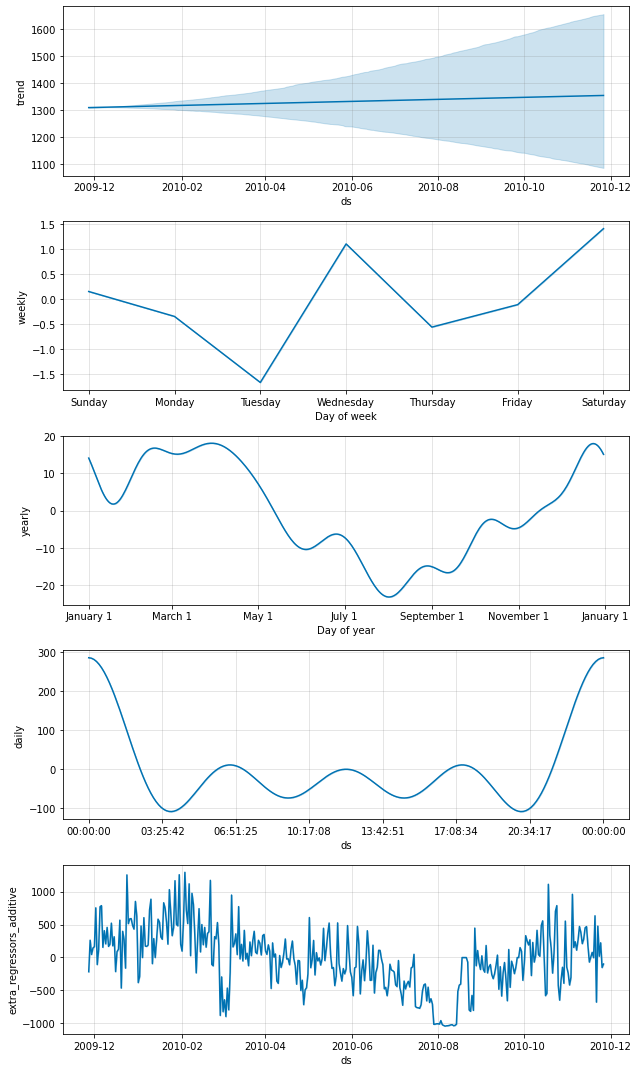

In [30]:
new_model.plot_components(forecast);